### Fusion des bases de données `df_regressions` et `ee_bp19`

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
df1 = pd.read_csv("df_regressions.csv")
df2 = pd.read_csv("ee_bp19.csv")
df2['D'] = df2['D']/100
# Fusion des deux dataframes
df = df1.merge(df2, on="Dep")

In [8]:
df.head()

,Dep,D9/D1,Rev_median,Ndip25_34,intens_pauvr,chom19,chom24,Dem_empl15_64,tauxpauvrete,G,C,D
0,Ain,3.5,24810.0,11.5,20.4,6.050,5.600,10.3,10.8,0.230103,0.327883,0.4082
1,Aisne,3.1,20920.0,17.6,20.1,11.800,10.500,15.8,18.8,0.179010,0.237194,0.5368
2,Allier,3.0,21500.0,14.8,20.1,9.050,7.925,13.7,16.2,0.206867,0.306293,0.4495
3,Alpes-de-Haute-Provence,3.2,21790.0,12.7,20.5,10.075,7.925,16.0,17.1,0.262900,0.291808,0.4082
4,Hautes-Alpes,3.0,22010.0,9.7,19.9,7.925,6.225,15.8,14.7,0.279853,0.313522,0.3756


### Régression linéaire

In [1]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [23]:

# 2. Définition des variables explicatives (X) et cibles (Y)
features_cols = ['D9/D1', 'Rev_median', 'Ndip25_34', 'chom19', 'Dem_empl15_64', 'tauxpauvrete']

X = df[features_cols]

# Optionnel mais recommandé : Standardiser les X pour comparer l'importance des coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features_cols)

# Ajout d'une constante (indispensable pour statsmodels pour avoir l'ordonnée à l'origine)
X_final = sm.add_constant(X_scaled)

# --- 3. RÉGRESSIONS ET AFFICHAGE COMPLET ---
partis = {'GAUCHE': 'G', 'CENTRE': 'C', 'DROITE': 'D'}

# Dictionnaire pour stocker un résumé synthétique si besoin
resume_significativite = pd.DataFrame(index=features_cols)

print(" ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ".center(80, "="))

for nom, col in partis.items():
    y = df[col]
    
    # Ajustement du modèle
    model = sm.OLS(y, X_final)
    
    # Note : Si tu lances ce code avec seulement 5 lignes et 8 variables, 
    # tu auras une erreur de degrés de liberté. 
    # Avec ton fichier complet, ça marchera nickel.
    try:
        results = model.fit(cov_type="HC1")
        
        print(f"\n\n{'#'*30}")
        print(f" RÉSULTATS POUR : {nom} ")
        print(f"{'#'*30}")
        
        # C'EST ICI : Le tableau complet avec coef, std err, t, P>|t|, [0.025, 0.975]
        print(results.summary())
        
        # On stocke les p-valeurs pour une vue d'ensemble à la fin
        resume_significativite[f'P-val {nom}'] = results.pvalues.drop('const')
        
    except Exception as e:
        print(f"\nErreur sur {nom} (probablement pas assez de données dans l'échantillon test) : {e}")

# --- 4. BONUS : VUE SYNTHÉTIQUE DES P-VALEURS ---
print("\n\n" + "="*80)
print(" RÉSUMÉ DES P-VALEURS (Seuil critique habituel : 0.05) ")
print("="*80)
# On formate pour afficher propre (rouge si significatif pourrait être fait avec des bibliothèques de style)
print(resume_significativite.round(4))

======================== ANALYSE ÉCONOMÉTRIQUE COMPLÈTE ========================


##############################
 RÉSULTATS POUR : GAUCHE 
##############################
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     17.48
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           4.00e-13
Time:                        14:02:22   Log-Likelihood:                 204.68
No. Observations:                  93   AIC:                            -395.4
Df Residuals:                      86   BIC:                            -377.6
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                    coef    std err    

##### Vérification modèle de régression linéaire

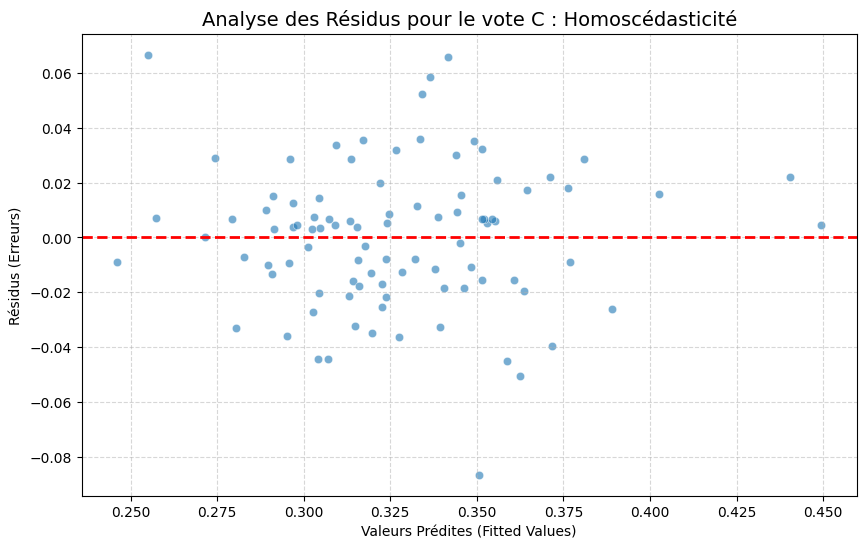

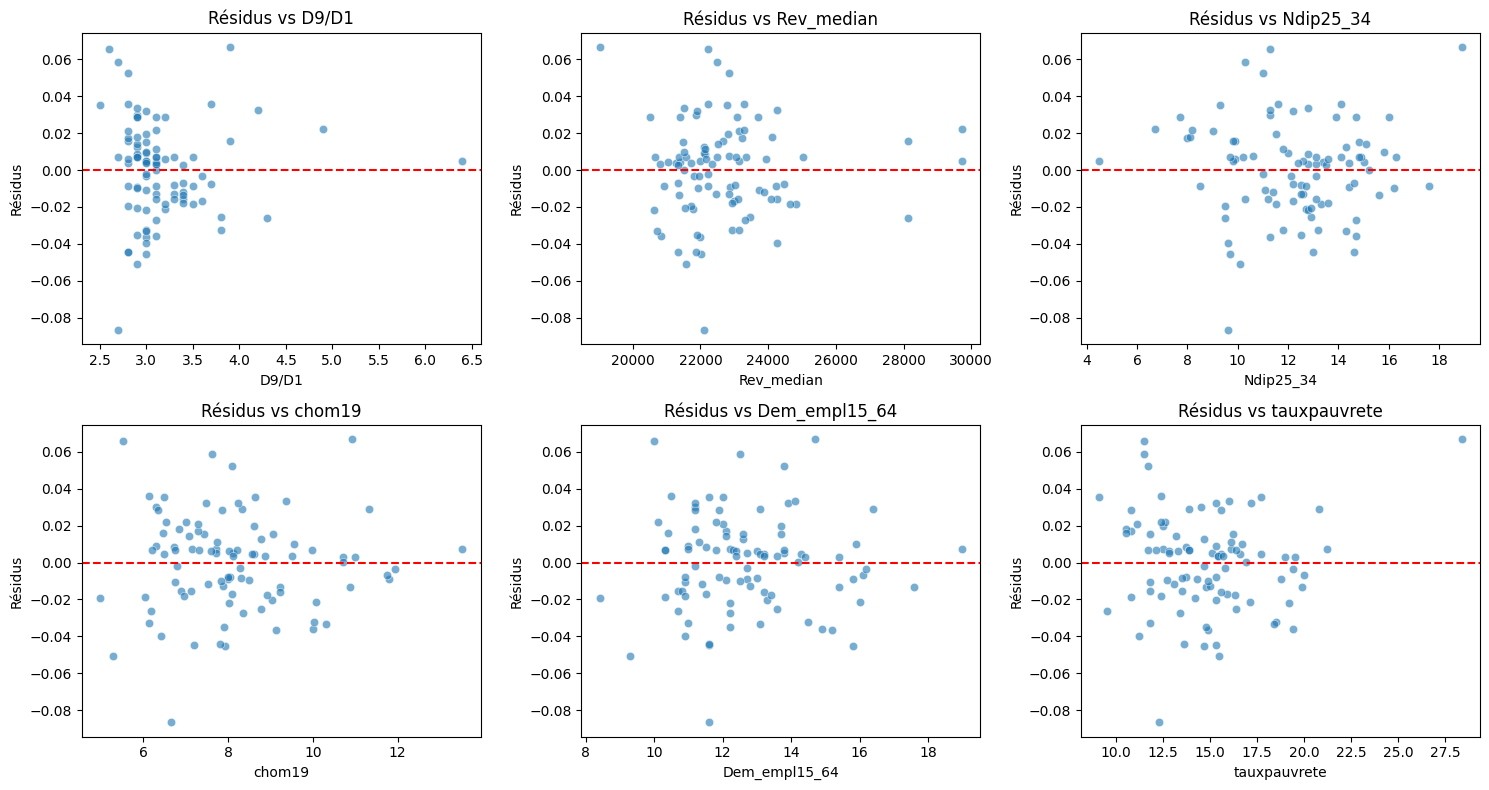

--- Corrélation entre les résidus et les variables explicatives (C) ---
D9/D1           -2.006624e-15
Rev_median      -2.631840e-15
Ndip25_34        2.291890e-15
chom19           1.624157e-15
Dem_empl15_64    1.280197e-15
tauxpauvrete     1.395963e-15
dtype: float64


In [27]:
# --- (On reprend ton df et le modèle précédent) ---
# Je simule un contexte où le modèle 'results' est déjà entraîné sur le 'Centre' (C) par exemple.
# Assure-toi d'avoir lancé le bloc de code précédent avant celui-ci.

# Exemple pour le parti du CENTRE (ou change pour G ou D)
target_col = 'C' 
y = df[target_col]
# On refit le modèle pour être sûr d'avoir l'objet 'results'
model = sm.OLS(y, X_final)
try:
    results = model.fit(cov_type='HC1')
    
    # Récupération des résidus et des prédictions
    residus = results.resid
    predictions = results.fittedvalues
    
    # ==============================================================================
    # 1. GRAPHE GLOBAL : RÉSIDUS vs VALEURS PRÉDITES (Fitted Values)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predictions, y=residus, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2) # Ligne zéro
    plt.title(f'Analyse des Résidus pour le vote {target_col} : Homoscédasticité', fontsize=14)
    plt.xlabel('Valeurs Prédites (Fitted Values)')
    plt.ylabel('Résidus (Erreurs)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ==============================================================================
    # 2. CHECK DÉTAILLÉ : RÉSIDUS vs VARIABLES EXPLICATIVES
    # ==============================================================================
    # On vérifie si une variable explicative contient encore de l'info non capturée (forme courbe, etc.)
    
    # On prend les variables principales (excluant la constante)
    vars_to_check = features_cols 
    
    # Création d'une grille de graphiques
    n_cols = 3
    n_rows = (len(vars_to_check) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() # Aplatir pour itérer facilement

    for i, col_name in enumerate(vars_to_check):
        sns.scatterplot(x=df[col_name], y=residus, ax=axes[i], alpha=0.6)
        axes[i].axhline(0, color='red', linestyle='--', lw=1.5)
        axes[i].set_title(f'Résidus vs {col_name}')
        axes[i].set_ylabel('Résidus')
        axes[i].set_xlabel(col_name)

    # Supprimer les graphiques vides s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # 3. VERIFICATION MATHÉMATIQUE (CORRÉLATION)
    # ==============================================================================
    print(f"--- Corrélation entre les résidus et les variables explicatives ({target_col}) ---")
    # On s'attend à des valeurs très proches de 0 (ex: 1e-10) par construction OLS
    correlation_check = df[features_cols].apply(lambda x: x.corr(residus))
    print(correlation_check)

except Exception as e:
    print(f"Erreur (probablement due au manque de données dans l'échantillon test) : {e}")

### Méthode K-means

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 2. On garde les colonnes numériques pour le kmeans
cols_kmeans = [
    "D9/D1", "Rev_median", "Ndip25_34", "intens_pauvr",
    "chom19", "chom24", "Dem_empl15_64", "tauxpauvrete",
    "G", "C", "D"
]

#X = df[cols_kmeans]
X = df2[["G", "C", "D"]]

# --- 3. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. K-means
k = 3   # par exemple, tu peux choisir 3 clusters (gauche / centre / droite)
kmeans = KMeans(n_clusters=k, random_state=0)
df2["cluster"] = kmeans.fit_predict(X_scaled)

# --- 5. Résultat
print(df2[["Dep", "cluster"]])


                        Dep  cluster
0                       Ain        0
1                     Aisne        1
2                    Allier        1
3   Alpes-de-Haute-Provence        0
4              Hautes-Alpes        0
..                      ...      ...
95               Val-d'Oise        2
96               Guadeloupe        2
97               Martinique        2
98                   Guyane        2
99               La Réunion        0

[100 rows x 2 columns]


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

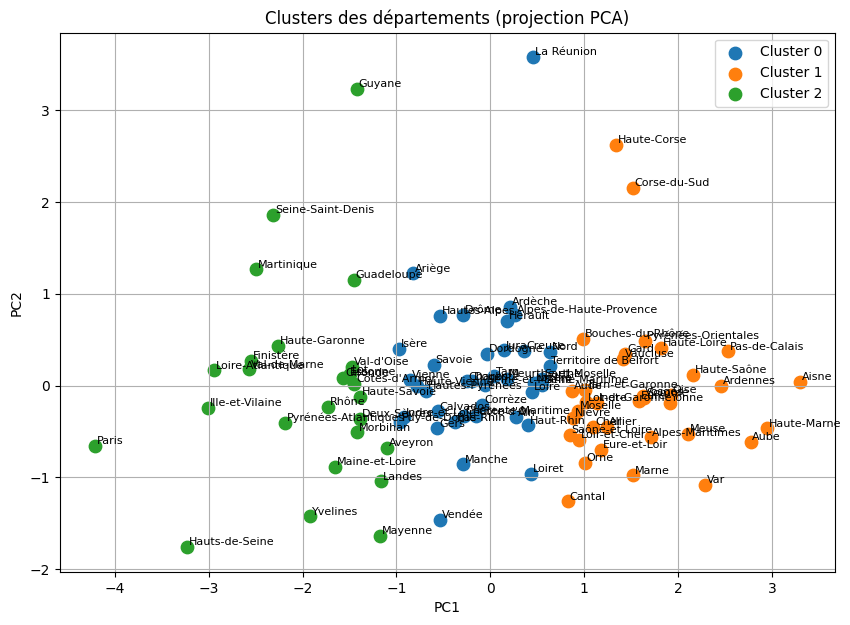

In [17]:
# --- 5. PCA pour projeter en 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df2["PC1"] = X_pca[:, 0]
df2["PC2"] = X_pca[:, 1]

# --- 6. Visualisation ---
plt.figure(figsize=(10, 7))
for cluster in df2["cluster"].unique():
    subset = df2[df2["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", s=80)

# Ajouter les labels (noms des départements)
for i in range(len(df2)):
    plt.text(df2["PC1"][i] + 0.02, df2["PC2"][i] + 0.02, df2["Dep"][i], fontsize=8)

plt.title("Clusters des départements (projection PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

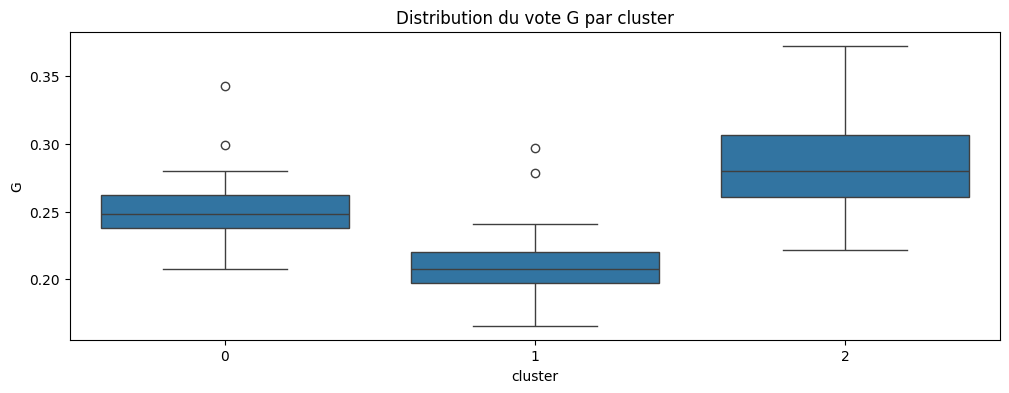

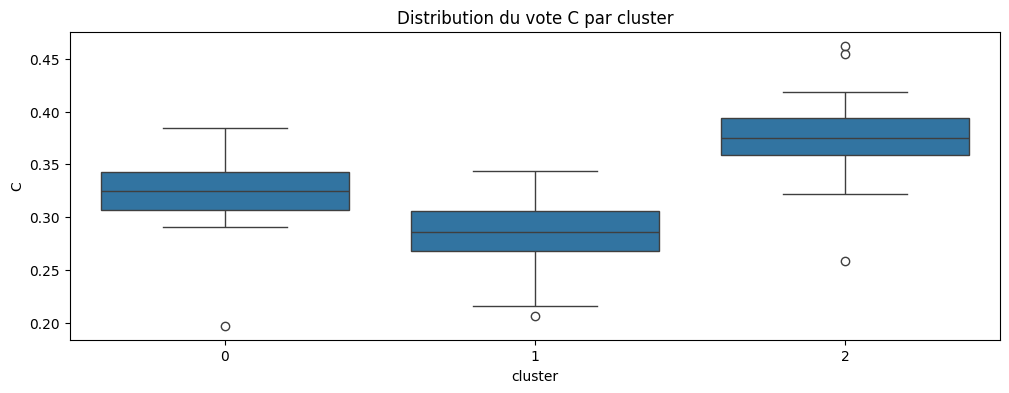

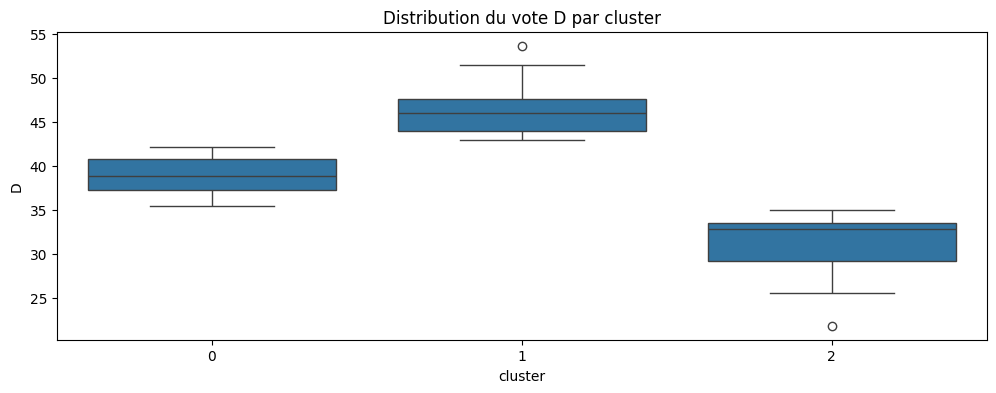

In [19]:
import seaborn as sns

plt.figure(figsize=(12,4))
sns.boxplot(data=df2, x="cluster", y="G")
plt.title("Distribution du vote G par cluster")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df2, x="cluster", y="C")
plt.title("Distribution du vote C par cluster")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df2, x="cluster", y="D")
plt.title("Distribution du vote D par cluster")
plt.show()
